# Load and Preprocess Data

### Preprocess data to ensure all images are ready for model training and testing
#### Image dataset is from kaggle [here](https://www.kaggle.com/datasets/darren2020/ct-to-mri-cgan)

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch, torchvision

In [3]:
DATASET_ROOT_PATH = "Dataset/images"
TRAIN_ROOT_PATH = "Dataset/images/train"
TEST_ROOT_PATH = "Dataset/images/test"

CT_TRAIN_PATH = "Dataset/images/train/trainA"
MRI_TRAIN_PATH = "Dataset/images/train/trainB"

CT_TEST_PATH = "Dataset/images/test/testA"
MRI_TEST_PATH = "Dataset/images/test/testB"

224 224


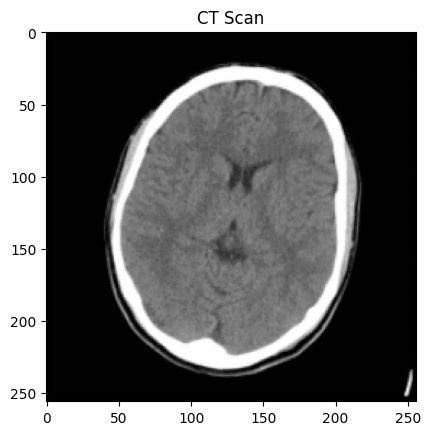

In [4]:
test_CT = cv.imread(CT_TRAIN_PATH+'/ct1.png')

### get image dimensions (and resize)
height, width, channels = test_CT.shape
print(height, width)
test_CT = cv.resize(test_CT, (256, 256))

### display image
plt.title("CT Scan")
plt.imshow(test_CT)

224 224


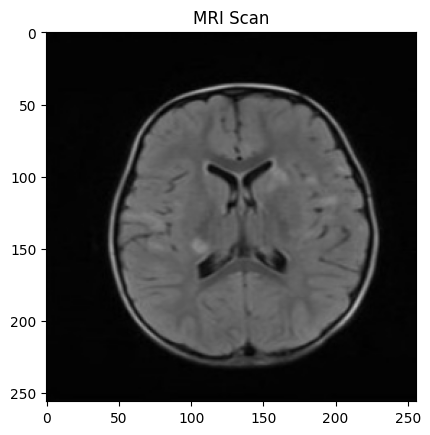

In [5]:
test_MRI = cv.imread(MRI_TRAIN_PATH+'/mri1.jpg')

### get image dimensions (and resize)
height, width, channels = test_MRI.shape
print(height, width)
test_MRI = cv.resize(test_MRI, (256, 256))

### display image
plt.title("MRI Scan")
plt.imshow(test_MRI)

Notice that the CT and MRI images are of different dimensions. Therefore the dimensions must be made constant across all images

### Resize all images to have the same dimensions

In [6]:
### resize MRI images to 512x512 and overwrite the image
def resize(image_path):
    image = cv.imread(image_path)
    height, width, channels = image.shape
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)    
    if height != 224 and width != 224:      
        image = cv.resize(image, (224, 224))
    # overwrite image
    cv.imwrite(image_path, image)

In [7]:
### resize all images
import os

for images in os.walk(CT_TRAIN_PATH):
    for image in images[2]:
        resize(CT_TRAIN_PATH+'/'+image)

for images in os.walk(CT_TEST_PATH):
    for image in images[2]:
        resize(CT_TEST_PATH+'/'+image)
 
for images in os.walk(MRI_TRAIN_PATH):
    for image in images[2]:
        resize(MRI_TRAIN_PATH+'/'+image)
 
for images in os.walk(MRI_TEST_PATH):
    for image in images[2]:
        resize(MRI_TEST_PATH+'/'+image)
 

In [8]:
### test if images are of same dimensions now

test_MRI = cv.imread(MRI_TRAIN_PATH+'/mri561.jpg')

### get image dimensions (and resize)
height, width, channels = test_MRI.shape
print(height, width, channels)

224 224 3


### Normalize the dataset

In [9]:
def normalize(image):
    image = (image/127.5) - 1
    return image

normalize_transform = transforms.Lambda(normalize)


In [22]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

In [23]:
train_dataset = datasets.ImageFolder(TRAIN_ROOT_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(TRAIN_ROOT_PATH, transform=test_transform)

### 80-20 split of training and validation data
train_set, _ = torch.utils.data.random_split(train_dataset, [2788, 698])
_, val_set = torch.utils.data.random_split(val_dataset, [2788, 698])

test_dataset = datasets.ImageFolder(TEST_ROOT_PATH, transform=test_transform)

### create dataloaders

In [24]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

### display some images

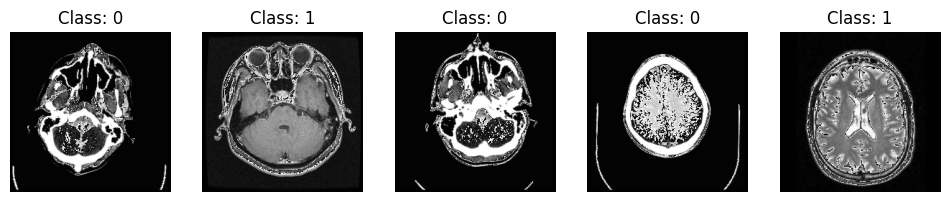

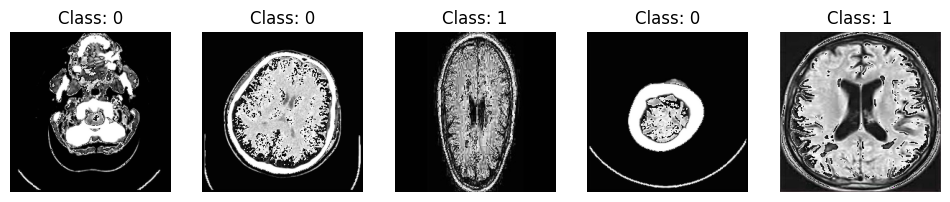

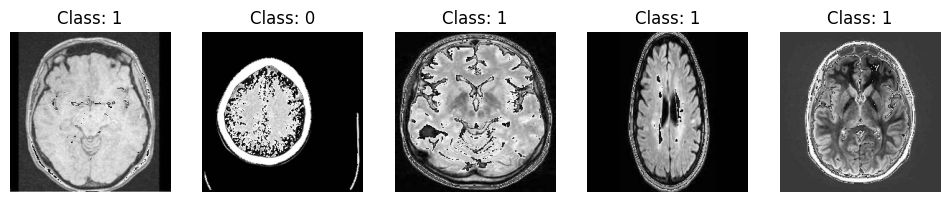

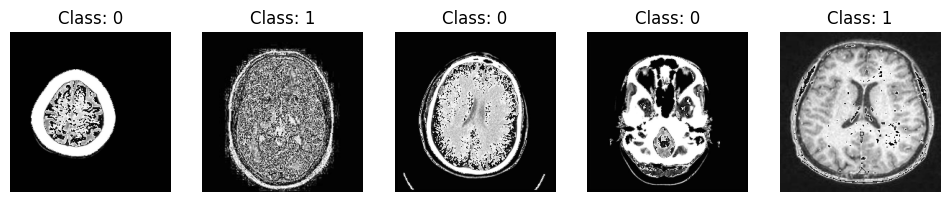

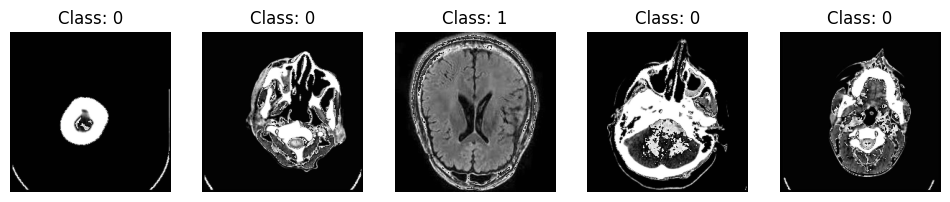

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image_np = (image * 255).byte().numpy()
        axes[idx].imshow(np.transpose(image_np, (1, 2, 0)))
        axes[idx].set_title(f"Class: {label}")
        axes[idx].axis('off')
    plt.show()

# Iterate over the data loader and display some images
count = 0
for batch_images, batch_labels in train_loader:
    show_images(batch_images[:5], batch_labels[:5])  # Display first 5 images
    count = count + 1
    if count == 5:
        break

# Model

### There are two parts to a GAN: A generator (G) and Discriminator (D). A cyclegan has two sets of GANs that translate from one domain to another and vice versa. 

In [1]:
import torch
import torch.nn as nn

In [2]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, 
                 downsampling: bool=True, activation: bool=True):
        super().__init__()
        # downsampling block used first in G
        if downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect"),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if activation else nn.Identity()
            )
        # upsampling block used last in G
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels),
                nn.InstanceNorm2d(out_channels),
                nn.Relu(inplace=True) if activation else nn.Identity()
            )
    
    def forward(self, x):
        return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        self.block = nn.Sequential(\
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        return x + self.block(x) # add x to alleviate "vanishing gradient problem"